<a href="https://colab.research.google.com/github/scottspurlock/csc4466-s2024/blob/main/demos/day21_tutorial_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Day 21 Tutorial: Autoencoders
Adapted from https://www.tensorflow.org/tutorials/generative/autoencoder

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)


(60000, 28, 28)
(10000, 28, 28)


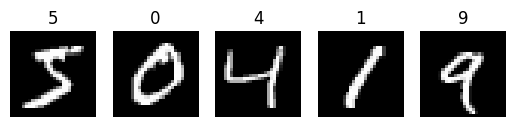

In [9]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

### Simple vanilla model

In [10]:
class Autoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
            layers.Reshape(shape)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


shape = (28, 28)
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


### Loss function

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using x_train as both the input and the target. The encoder will learn to compress the dataset from 784 dimensions to the latent space, and the decoder will learn to reconstruct the original images.

In [12]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0236 - val_loss: 0.0090
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.00

In [13]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                50240     
                                                                 
Total params: 50240 (196.25 KB)
Trainable params: 50240 (196.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 784)               50960     
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 50960 (199.06 KB)
Trainable params: 50960 (199.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [15]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

print(x_test.shape)
print(encoded_imgs.shape)
print(decoded_imgs.shape)

(10000, 28, 28)
(10000, 64)
(10000, 28, 28)


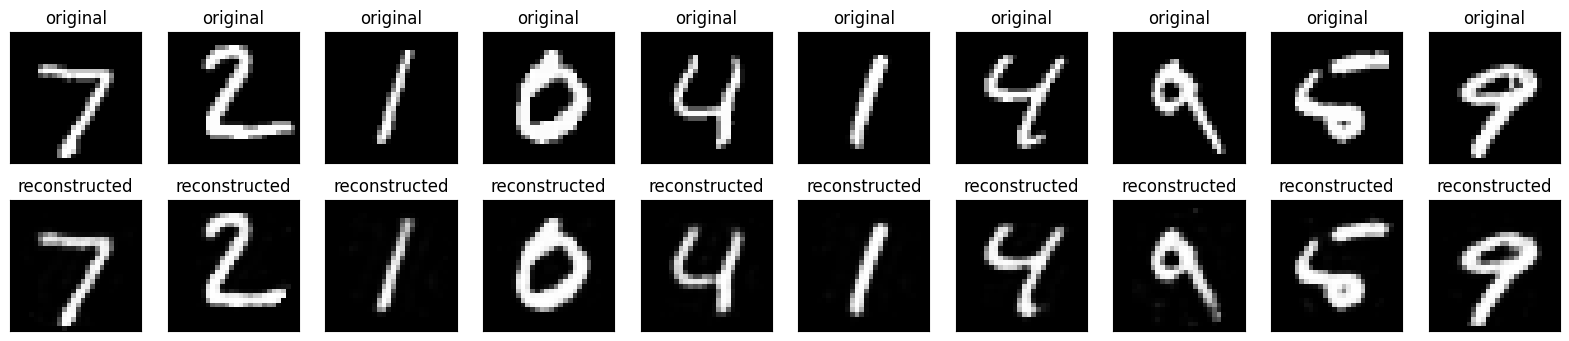

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


# Visualize the latent space
We can't plot 64 dimensional data easily, so let's reduce the dimensionality to 2 using TSNE.


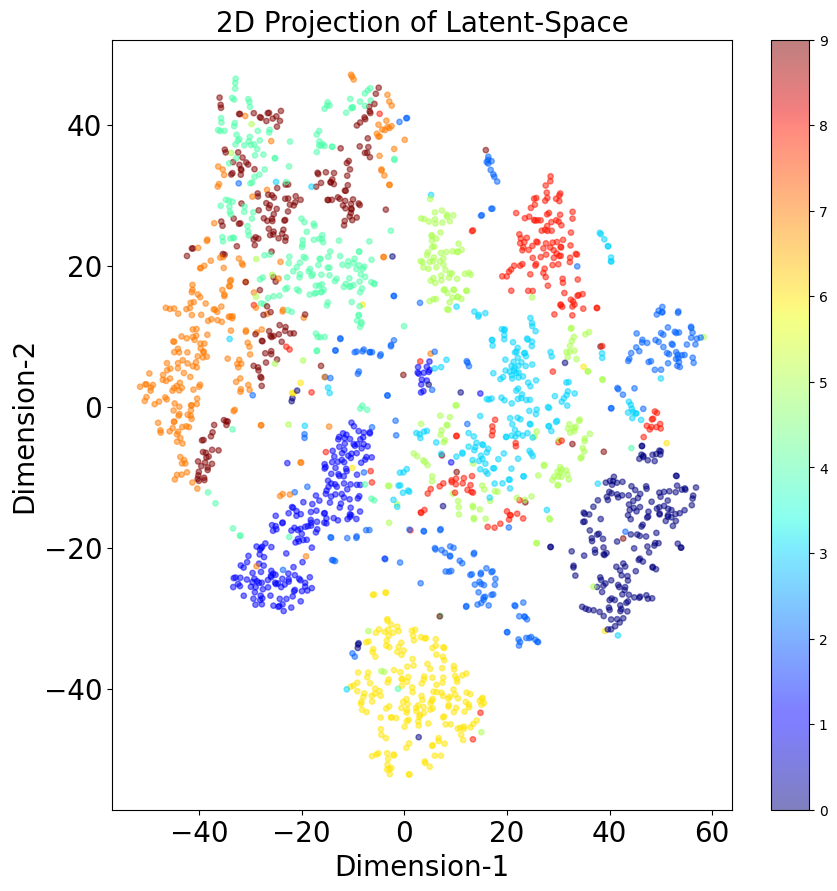

In [17]:
from sklearn.manifold import TSNE

z = autoencoder.encoder(x_train[:2000]).numpy()
z = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], 15, c=y_train[:2000], cmap='jet', alpha=0.5)
plt.colorbar()
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("2D Projection of Latent-Space", size=20)
plt.show()


# Convolutional autoencoder

In [18]:
class CAE(Model):
  def __init__(self):
    super(CAE, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = CAE()

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/10
1875/1875 [==============================] - 56s 29ms/step - loss: 0.0120 - val_loss: 0.0020
Epoch 2/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/10
1875/1875 [==============================] - 53s 29ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0011 - val_loss: 9.9112e-04
Epoch 6/10
1875/1875 [==============================] - 52s 28ms/step - loss: 9.5709e-04 - val_loss: 9.0911e-04
Epoch 7/10
1875/1875 [==============================] - 51s 27ms/step - loss: 9.0611e-04 - val_loss: 8.8380e-04
Epoch 8/10
1875/1875 [==============================] - 52s 28ms/step - loss: 8.7360e-04 - val_loss: 8.4812e-04
Epoch 9/10
1875/1875 [==============================] - 52s 28ms/step - loss: 8.4721e-04 - val_loss: 8.2568e-04
Epoch 10/10
1875/1875 [=====

## Visualize latent space

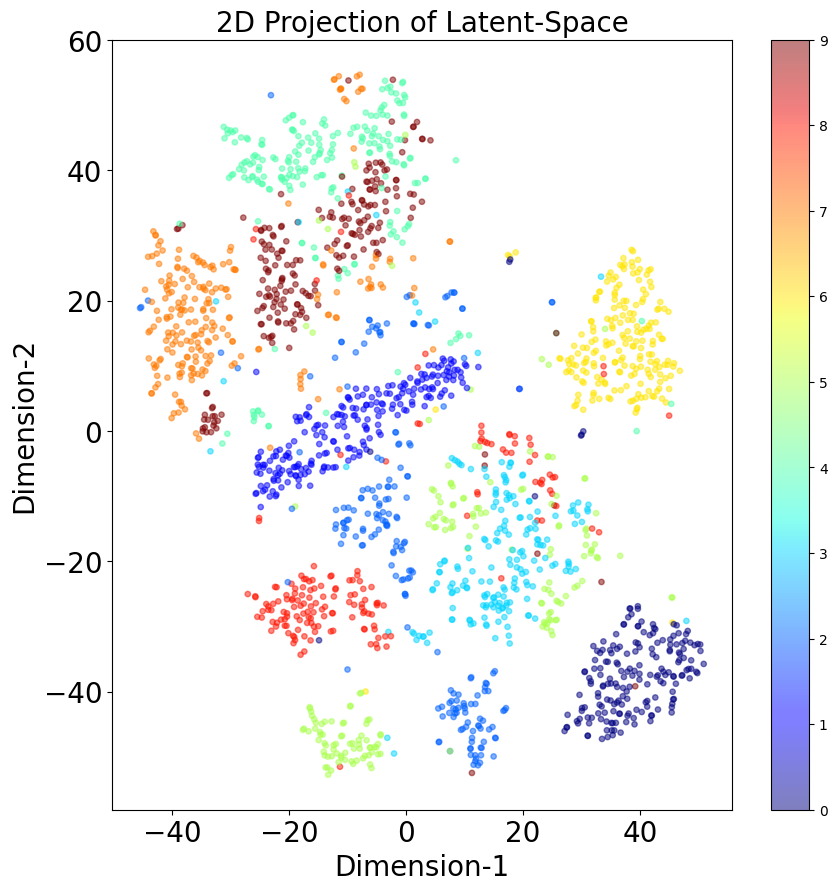

In [19]:
from sklearn.manifold import TSNE

z = autoencoder.encoder(x_train[:2000]).numpy()
z = np.reshape(z, (2000, -1))
z = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], 15, c=y_train[:2000], cmap='jet', alpha=0.5)
plt.colorbar()
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("2D Projection of Latent-Space", size=20)
plt.show()


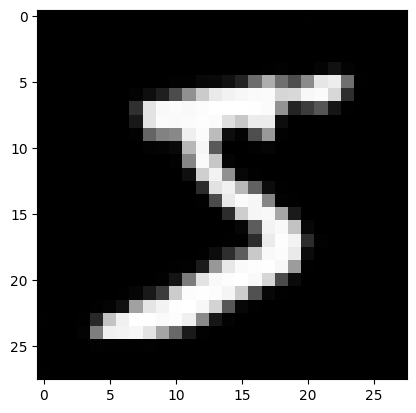

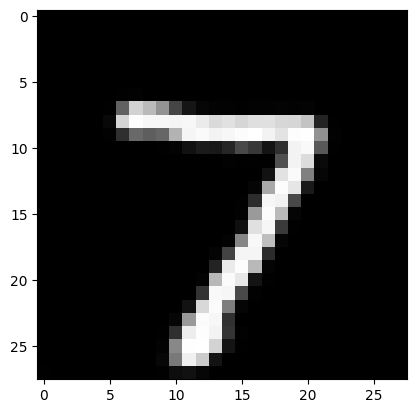

In [20]:
encoded_imgs_train = autoencoder.encoder(x_train).numpy()
decoded_imgs_train = autoencoder.decoder(encoded_imgs_train).numpy()
plt.imshow(decoded_imgs_train[0], cmap='gray')
plt.show()

encoded_imgs_test = autoencoder.encoder(x_test).numpy()
decoded_imgs_test = autoencoder.decoder(encoded_imgs_test).numpy()
plt.imshow(decoded_imgs_test[0], cmap='gray')

# Content-based image retrieval

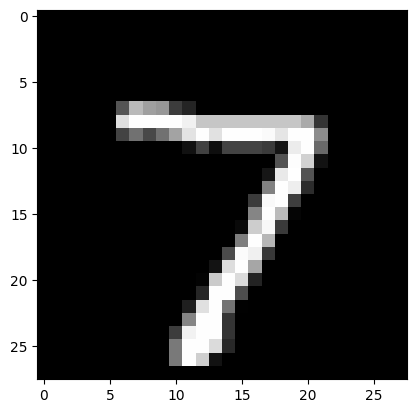

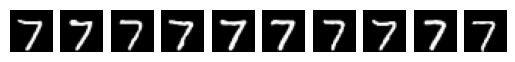

In [21]:
# most similar training image to the first test image?
plt.imshow(x_test[0], cmap='gray')
plt.show()

diffs = encoded_imgs_train - encoded_imgs_test[0]
sqd = diffs ** 2
ssd = np.sum(sqd, axis=(1, 2, 3))
sorted_indexes = np.argsort(ssd)

for i in range(10):
    curr_idx = sorted_indexes[i]
    img = decoded_imgs_train[curr_idx]
    plt.subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Generating images

Text(0.5, 1.0, 'halfway between')

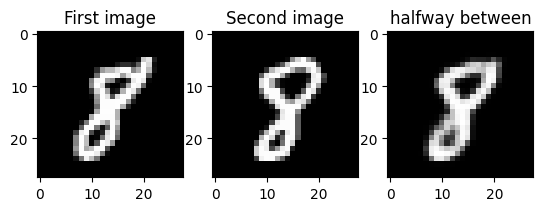

In [45]:
eight_mask = y_train == 8
just_eights = x_train[eight_mask]
idx1 = 0
idx2 = 6
enc1 = autoencoder.encoder(np.reshape(just_eights[idx1], (1, 28, 28)))
enc2 = autoencoder.encoder(np.reshape(just_eights[idx2], (1, 28, 28)))
enc3 = (enc1 + enc2) / 2
dec3 = autoencoder.decoder(enc3)
dec3 = np.reshape(dec3, (28, 28))

plt.subplot(1, 3, 1)
plt.imshow(just_eights[idx1], cmap='gray')
plt.title('First image')

plt.subplot(1, 3, 2)
plt.imshow(just_eights[idx2], cmap='gray')
plt.title('Second image')

plt.subplot(1, 3, 3)
plt.imshow(dec3, cmap='gray')
plt.title('halfway between')

## interpolating between images doesn't always work the way we'd prefer
Probably a Variational Autoendcoder would work better

Text(0.5, 1.0, 'halfway between')

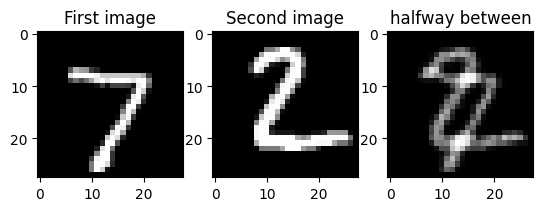

In [ ]:
enc1 = autoencoder.encoder(np.reshape(x_test[0], (1, 28, 28)))
enc2 = autoencoder.encoder(np.reshape(x_test[1], (1, 28, 28)))
enc3 = (enc1 + enc2) / 2
dec3 = autoencoder.decoder(enc3)
dec3 = np.reshape(dec3, (28, 28))

plt.subplot(1, 3, 1)
plt.imshow(x_test[0], cmap='gray')
plt.title('First image')

plt.subplot(1, 3, 2)
plt.imshow(x_test[1], cmap='gray')
plt.title('Second image')

plt.subplot(1, 3, 3)
plt.imshow(dec3, cmap='gray')
plt.title('halfway between')